# CMPE332L: Project 3 | Machine Learning with noaa_significant_earthquakes Dataset in Google Cloud's BigQuery

## Collaborators:
*Areesha Kaleem 2022-CE-15*

## Project Overview

**Project Objective:**
The objective of this project is to build a machine learning model for earthquake prediction and impact assessment using the NOAA Significant Earthquakes dataset available on Google Cloud's BigQuery public dataset platform. The dataset contains comprehensive information on historical significant earthquakes, including magnitudes, locations, dates, and impact parameters.

**Key Steps:**

**Data Exploration:** Explore the NOAA Significant Earthquakes dataset to understand its structure, distributions of earthquake magnitudes, impacts, and other relevant features. Identify key variables that influence earthquake intensity and impact.

**Preprocessing:** Clean and preprocess the data to handle missing values, outliers, and format the data appropriately for machine learning tasks. This step ensures data quality and compatibility with ML algorithms.

**Feature Engineering:** Extract meaningful features from the dataset such as seismic activity patterns, historical earthquake data, and geological factors. Create new features or transformations to enhance the model's predictive capabilities.

**Model Training:** Select suitable machine learning algorithms (e.g., regression for intensity prediction, clustering for aftershock forecasting) and train the model using preprocessed data. Evaluate different models based on performance metrics such as accuracy, precision, and recall.

**Evaluation and Optimization:** Evaluate the trained models' performance using validation data and optimize them by fine-tuning hyperparameters, addressing overfitting/underfitting issues, and improving generalization.

**Deployment:** Deploy the optimized ML models to a cloud-based environment for real-time earthquake prediction and impact assessment. Integrate the models into existing earthquake monitoring systems to provide timely warnings, aftershock forecasts, and damage assessments.
Expected Outcome:

A machine learning model capable of predicting earthquake intensity, forecasting aftershocks, improving tsunami warnings, assessing earthquake impact, and creating risk maps based on historical data.
Enhanced earthquake risk assessment and preparedness measures for various sectors including disaster management, infrastructure planning, and public safety.

**Significance:**
This project holds significant importance in advancing earthquake prediction and impact assessment capabilities using machine learning techniques. The outcomes can benefit various stakeholders including government agencies, disaster response teams, urban planners, and communities at risk, enabling them to make informed decisions, allocate resources efficiently, and mitigate the impact of seismic events.

## Analysis of Dataset

**Imports**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from google.colab import auth
auth.authenticate_user()
project_id = "akprojectdb01365"

**Connect to bigquery**

In [3]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project = project_id)

In [4]:
%%bigquery coords --project $project_id

SELECT latitude,longitude FROM `bigquery-public-data.noaa_significant_earthquakes.earthquakes`

Query is running:   0%|          |

Downloading:   0%|          |

**Question no 1:**

*Filter the Null values from intensity column*
Next will train model for intensity prediction.

In [ ]:
%%bigquery --project akprojectdb01365

SELECT intensity, location_name, latitude, longitude FROM `bigquery-public-data.noaa_significant_earthquakes.earthquakes` where intensity is not null LIMIT 1000

Query is running:   0%|          |

Downloading:   0%|          |

,intensity,location_name,latitude,longitude
0,4,"BOSTON AND SALEM, MASSACHUSETTS",42.35,-71.05
1,8,MASSACHUSETTS: EAST OF CAPE ANN,42.70,-70.30
2,10,ARKANSAS: NORTHEAST (NEW MADRID EARTHQUAKES),35.60,-90.40
3,10,MISSOURI: NEW MADRID,36.30,-89.60
4,10,CALIFORNIA,38.00,-122.00
...,...,...,...,...
995,9,UZBEKISTAN: AKHSY,40.90,71.40
996,9,UZBEKISTAN: UZGUT,39.40,67.20
997,8,UZBEKISTAN: TASHKENT; KAZAKHSTAN: TURKESTAN,41.20,69.60
998,7,UZBEKISTAN: GAZLI,40.31,63.77


**Made a dataset in bigquery to keep models**

In [ ]:
# Run this cell to create a dataset to store your model, or create in the UI

model_dataset_name = 'eqml_eqpredict'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('akprojectdb01365', 'eqml_eqpredict'))

*Trained intensity model which will predict intensity on the base of latitude and longitude of the area*

In [ ]:
%%bigquery --project akprojectdb01365
CREATE OR REPLACE MODEL eqml_eqpredict.eq_intensity_model
OPTIONS(
  model_type='logistic_reg',
  input_label_cols=['intensity_class'],
  auto_class_weights=TRUE,
  max_iterations=30,  -- Adjust as needed
  l2_reg=0.1           -- Regularization strength, adjust as needed
) AS
SELECT
  latitude,
  longitude,
  CASE WHEN intensity >= 5 THEN 1 ELSE 0 END AS intensity_class
FROM
  `bigquery-public-data.noaa_significant_earthquakes.earthquakes`
WHERE
  intensity IS NOT NULL;

Query is running:   0%|          |

""


**Model training time and learning rate**

In [ ]:
%%bigquery --project akprojectdb01365

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL eqml_eqpredict.eq_intensity_model)
  where iteration >= 0;

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,1,0.692355,0.691334,0.4,2439
1,0,0,0.692826,0.692466,0.2,2117


**Accuracy rate of the trained model**

In [ ]:
%%bigquery --project  akprojectdb01365

SELECT
  *
FROM
  ML.EVALUATE(MODEL eqml_eqpredict.eq_intensity_model,
              (
                SELECT
                  latitude,
                  longitude,
                  CASE WHEN intensity >= 5 THEN 1 ELSE 0 END AS intensity_class
                FROM
                  bigquery-public-data.noaa_significant_earthquakes.earthquakes
                WHERE
                  intensity IS NOT NULL
              )
            );

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.979088,0.642958,0.641349,0.776196,0.692134,0.655664


**Prediction query for Intensity model**

In [ ]:
%%bigquery --project akprojectdb01365

SELECT
  latitude,
  longitude,
  predicted_intensity_class
FROM
  ML.PREDICT(MODEL eqml_eqpredict.eq_intensity_model,
             (
               SELECT
                 latitude,
                 longitude
               FROM
                 bigquery-public-data.noaa_significant_earthquakes.earthquakes
               WHERE
                 intensity IS NULL and latitude IS NOT NULL and longitude IS NOT NULL
             )
           ) AS predicted_earthquakes;

Query is running:   0%|          |

Downloading:   0%|          |

,latitude,longitude,predicted_intensity_class
0,51.019,1.309,1
1,49.920,-6.320,1
2,55.000,-161.000,1
3,39.950,-75.100,1
4,54.520,-164.650,1
...,...,...,...
3279,-43.564,172.743,0
3280,14.924,120.497,0
3281,6.708,125.188,0
3282,38.650,-28.626,1


**Question no 2**

*Flag_tsunami column will be used for tsunami prediction*

In [ ]:
%%bigquery --project akprojectdb01365
SELECT flag_tsunami, latitude, longitude FROM `bigquery-public-data.noaa_significant_earthquakes.earthquakes` LIMIT 1000


Query is running:   0%|          |

Downloading:   0%|          |

,flag_tsunami,latitude,longitude
0,None,52.000,NaN
1,Tsu,51.019,1.309
2,Tsu,49.920,-6.320
3,Tsu,NaN,NaN
4,Tsu,42.350,-71.050
...,...,...,...
995,Tsu,31.789,131.314
996,None,31.920,130.429
997,Tsu,31.959,141.878
998,Tsu,39.027,143.441


**Trained model for tsunami predict on earthquakes dataset by noaa**

In [ ]:
%%bigquery --project akprojectdb01365
CREATE OR REPLACE MODEL eqml_eqpredict.eq_tsunami_model
OPTIONS(
  model_type='logistic_reg',
  input_label_cols=['tsunami_class'],
  auto_class_weights=TRUE,
  max_iterations=40,  -- Adjust as needed
  l2_reg=0.5           -- Regularization strength, adjust as needed
) AS
SELECT
  latitude,
  longitude,
  CASE WHEN flag_tsunami IS NOT NULL THEN 1 ELSE 0 END AS tsunami_class
FROM
  `bigquery-public-data.noaa_significant_earthquakes.earthquakes`

Query is running:   0%|          |

""


**Training time and learning rate of Tsunami model**

In [ ]:
%%bigquery --project akprojectdb01365

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL eqml_eqpredict.eq_tsunami_model)
  where iteration >= 0;

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,1,0.688186,0.687074,0.4,2377
1,0,0,0.691334,0.690941,0.2,2240


**Accuracy rate of tsunami model**

In [ ]:
%%bigquery --project  akprojectdb01365

SELECT
  *
FROM
  ML.EVALUATE(MODEL eqml_eqpredict.eq_tsunami_model,
              (
                SELECT
                  latitude,
                  longitude,
                  CASE WHEN flag_tsunami IS NOT NULL THEN 1 ELSE 0 END AS tsunami_class
                FROM
                  bigquery-public-data.noaa_significant_earthquakes.earthquakes
              )
            );

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.386364,0.482076,0.617567,0.428945,0.68713,0.611856


**Prediction query for tsunami model**

In [ ]:
%%bigquery --project akprojectdb01365

SELECT
  latitude,
  longitude,
  predicted_tsunami_class
FROM
  ML.PREDICT(MODEL eqml_eqpredict.eq_tsunami_model,
             (
               SELECT
                 latitude,
                 longitude
               FROM
                 bigquery-public-data.noaa_significant_earthquakes.earthquakes
               WHERE
                 flag_tsunami IS NULL and latitude IS NOT NULL and longitude IS NOT NULL
             )
           ) AS predicted_earthquakes;

Query is running:   0%|          |

Downloading:   0%|          |

,latitude,longitude,predicted_tsunami_class
0,38.000,-122.000,0
1,35.500,-121.000,0
2,35.000,-119.000,0
3,37.500,-122.000,0
4,37.500,-122.000,0
...,...,...,...
4379,38.084,58.364,0
4380,-5.392,151.868,1
4381,-6.070,142.754,1
4382,38.650,-28.626,0


**Question no 3:**

*For high risk countries regarding earthquakes or in other words earthquake prediction based on geographic measures and location data extraction from noaa dataset*

In [ ]:
%%bigquery --project akprojectdb01365
SELECT
  country,
  latitude,
  longitude,
  COUNT(country) AS num_earthquakes
FROM (
  SELECT
    country,
    latitude,
    longitude
  FROM
    `bigquery-public-data.noaa_significant_earthquakes.earthquakes`

)
GROUP BY
  country,
  latitude,
  longitude
HAVING
  num_earthquakes > 1
ORDER BY
  country;

Query is running:   0%|          |

Downloading:   0%|          |

,country,latitude,longitude,num_earthquakes
0,AFGHANISTAN,36.50,70.50,6
1,AFGHANISTAN,36.00,70.50,2
2,ALBANIA,41.30,19.50,3
3,ALBANIA,41.20,19.30,5
4,ALBANIA,41.10,20.10,2
...,...,...,...,...
392,VANUATU,-15.50,167.20,2
393,VENEZUELA,10.50,-64.20,9
394,VENEZUELA,10.47,-64.17,2
395,YEMEN,14.10,43.20,3


**Trained model for earthquakes prediction on the basis of latitude, longitude and location mainly country name**

In [ ]:
%%bigquery --project akprojectdb01365
CREATE OR REPLACE MODEL eqml_eqpredict.eq_prediction_model
OPTIONS(
  model_type='logistic_reg',
  input_label_cols=['prediction_class'],
  auto_class_weights=TRUE,
  max_iterations=40,
  l2_reg=0.1
) AS
SELECT
  country,
  latitude,
  longitude,
  CASE WHEN num_earthquakes > 5 THEN 1 ELSE 0 END AS prediction_class
FROM (
  SELECT
    country,
    latitude,
    longitude,
    COUNT(*) AS num_earthquakes
  FROM
    `bigquery-public-data.noaa_significant_earthquakes.earthquakes`
  WHERE
    country IS NOT NULL
    AND latitude IS NOT NULL
    AND longitude IS NOT NULL
  GROUP BY
    country,
    latitude,
    longitude
  HAVING
    num_earthquakes > 1
)
ORDER BY
  country;

Query is running:   0%|          |

""


**Training time and prediction rate of earthquake prediction model**

In [ ]:
%%bigquery --project akprojectdb01365

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL eqml_eqpredict.eq_prediction_model)
  where iteration >= 0;

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,6,0.356358,NaN,12.8,5366
1,0,5,0.388669,NaN,6.4,2137
2,0,4,0.436060,NaN,3.2,1947
3,0,3,0.528093,NaN,1.6,2621
4,0,2,0.611716,NaN,0.8,2382
5,0,1,0.659572,NaN,0.4,2424
6,0,0,0.681658,NaN,0.2,2051


**Accuracy rate of prediction model**

In [ ]:
%%bigquery --project  akprojectdb01365

SELECT
  *
FROM
  ML.EVALUATE(MODEL eqml_eqpredict.eq_prediction_model,
                (SELECT
  country,
  latitude,
  longitude,
  CASE WHEN num_earthquakes > 5 THEN 1 ELSE 0 END AS prediction_class
FROM (
  SELECT
    country,
    latitude,
    longitude,
    COUNT(*) AS num_earthquakes
  FROM
    `bigquery-public-data.noaa_significant_earthquakes.earthquakes`
  WHERE
    country IS NOT NULL
    AND latitude IS NOT NULL
    AND longitude IS NOT NULL
  GROUP BY
    country,
    latitude,
    longitude
  HAVING
    num_earthquakes > 1
)
ORDER BY
  country)
            );

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.160714,1.0,0.756477,0.276923,0.356358,0.924988


**Prediction query for Earthquakes prediction based on geographic data and location**

In [ ]:
%%bigquery --project akprojectdb01365

SELECT
  country,
  latitude,
  longitude,
  predicted_prediction_class
FROM
  ML.PREDICT(MODEL eqml_eqpredict.eq_prediction_model,
  (
    SELECT
      country,
      latitude,
      longitude
    FROM
      `bigquery-public-data.noaa_significant_earthquakes.earthquakes`
    WHERE
      country IS NOT NULL
      AND latitude IS NOT NULL
      AND longitude IS NOT NULL
  )
)
ORDER BY
  country;

Query is running:   0%|          |

Downloading:   0%|          |

,country,latitude,longitude,predicted_prediction_class
0,AFGHANISTAN,35.000,62.100,1
1,AFGHANISTAN,36.500,71.000,1
2,AFGHANISTAN,34.400,70.500,1
3,AFGHANISTAN,35.000,69.000,1
4,AFGHANISTAN,37.000,71.000,1
...,...,...,...,...
6210,YEMEN,14.200,43.300,0
6211,YEMEN,13.887,44.068,0
6212,YEMEN,12.400,45.100,0
6213,YEMEN,14.701,44.379,0


**Question no 4**

*Extracting data to train model for aftershocks prediction*

In [5]:
%%bigquery --project akprojectdb01365
SELECT
  a.month,
  a.day,
  a.country,
  a.latitude,
  a.longitude
FROM
  `bigquery-public-data.noaa_significant_earthquakes.earthquakes` AS a
JOIN (
  SELECT
    month,
    day,
    country,
    latitude,
    longitude
  FROM
    `bigquery-public-data.noaa_significant_earthquakes.earthquakes`
  WHERE
    intensity > 4.5
) AS b
ON
  a.country = b.country
  AND (a.day - b.day) BETWEEN 1 AND 3
  AND ABS(a.latitude - b.latitude) < 1
  AND ABS(a.longitude - b.longitude) < 1
WHERE
  a.intensity > 2.5
ORDER BY
  a.month,
  a.day,
  a.country,
  a.latitude,
  a.longitude;


Query is running:   0%|          |

Downloading:   0%|          |

,month,day,country,latitude,longitude
0,1,2,ALBANIA,40.400,19.500
1,1,2,ALBANIA,40.400,19.500
2,1,2,ALGERIA,36.400,2.700
3,1,3,IRAN,37.140,57.899
4,1,3,IRAN,37.140,57.899
...,...,...,...,...,...
2118,12,31,GREECE,38.628,21.798
2119,12,31,GREECE,38.628,21.798
2120,12,31,GREECE,38.628,21.798
2121,12,31,GREECE,38.628,21.798


**Trained model for aftershocks prediction on the basis of latitude, location and longitude**

In [8]:
%%bigquery --project akprojectdb01365
CREATE OR REPLACE MODEL eqml_eqpredict.eq_aftershocks_model
OPTIONS(
  model_type='logistic_reg',
  input_label_cols=['aftershocks_class'],
  auto_class_weights=TRUE,
  max_iterations=40,
  l2_reg=0.1
) AS
SELECT
  a.month,
  a.day,
  a.country,
  a.latitude,
  a.longitude,
  CASE
    WHEN a.intensity > 4.5 THEN 1
    ELSE 0
  END AS aftershocks_class
FROM
  `bigquery-public-data.noaa_significant_earthquakes.earthquakes` AS a
JOIN (
  SELECT
    month,
    day,
    country,
    latitude,
    longitude
  FROM
    `bigquery-public-data.noaa_significant_earthquakes.earthquakes`
  WHERE
    intensity > 4.5
) AS b
ON
  a.country = b.country
  AND (a.day - b.day) BETWEEN 1 AND 3
  AND ABS(a.latitude - b.latitude) < 1
  AND ABS(a.longitude - b.longitude) < 1
WHERE
  a.intensity > 2.5
ORDER BY
  a.month,
  a.day,
  a.country,
  a.latitude,
  a.longitude;



Query is running:   0%|          |

""


**Training time and prediction rate of aftershocks prediction model**

In [9]:
%%bigquery --project akprojectdb01365

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL eqml_eqpredict.eq_aftershocks_model)
  where iteration >= 0;

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,6,0.373651,0.340355,12.8,2405
1,0,5,0.466675,0.448421,6.4,2429
2,0,4,0.494493,0.480241,3.2,2681
3,0,3,0.583273,0.575373,1.6,2367
4,0,2,0.652093,0.651205,0.8,3016
5,0,1,0.681365,0.683246,0.4,2456
6,0,0,0.690341,0.691955,0.2,2050


**Accuracy rate of aftershocks model**

In [10]:
%%bigquery --project akprojectdb01365
SELECT
  *
FROM
  ML.EVALUATE(MODEL eqml_eqpredict.eq_aftershocks_model,
    (
      SELECT
        a.month,
        a.day,
        a.country,
        a.latitude,
        a.longitude,
        CASE
          WHEN a.intensity > 4.5 THEN 1
          ELSE 0
        END AS aftershocks_class
      FROM
        `bigquery-public-data.noaa_significant_earthquakes.earthquakes` AS a
      JOIN (
        SELECT
          month,
          day,
          country,
          latitude,
          longitude
        FROM
          `bigquery-public-data.noaa_significant_earthquakes.earthquakes`
        WHERE
          intensity > 4.5
      ) AS b
      ON
        a.country = b.country
        AND (a.day - b.day) BETWEEN 1 AND 3
        AND ABS(a.latitude - b.latitude) < 1
        AND ABS(a.longitude - b.longitude) < 1
      WHERE
        a.intensity > 2.5
    )
  );


Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.994964,0.850311,0.848328,0.916968,0.36686,0.864586


**Prediction query for Aftershocks prediction based on geographic data and location**

In [13]:
%%bigquery --project akprojectdb01365

SELECT
  country,
  latitude,
  longitude,
  predicted_aftershocks_class
FROM
  ML.PREDICT(MODEL eqml_eqpredict.eq_aftershocks_model,
  (
    SELECT
      country,
      latitude,
      longitude,
      month,
      day
    FROM
      `bigquery-public-data.noaa_significant_earthquakes.earthquakes`
    WHERE
      country IS NOT NULL
      AND latitude IS NOT NULL
      AND longitude IS NOT NULL
  )
)
ORDER BY
  country;

Query is running:   0%|          |

Downloading:   0%|          |

,country,latitude,longitude,predicted_aftershocks_class
0,AFGHANISTAN,35.000,62.100,0
1,AFGHANISTAN,36.500,71.000,0
2,AFGHANISTAN,34.400,70.500,0
3,AFGHANISTAN,35.000,69.000,0
4,AFGHANISTAN,37.000,71.000,0
...,...,...,...,...
6210,YEMEN,14.200,43.300,1
6211,YEMEN,13.887,44.068,1
6212,YEMEN,12.400,45.100,1
6213,YEMEN,14.701,44.379,1


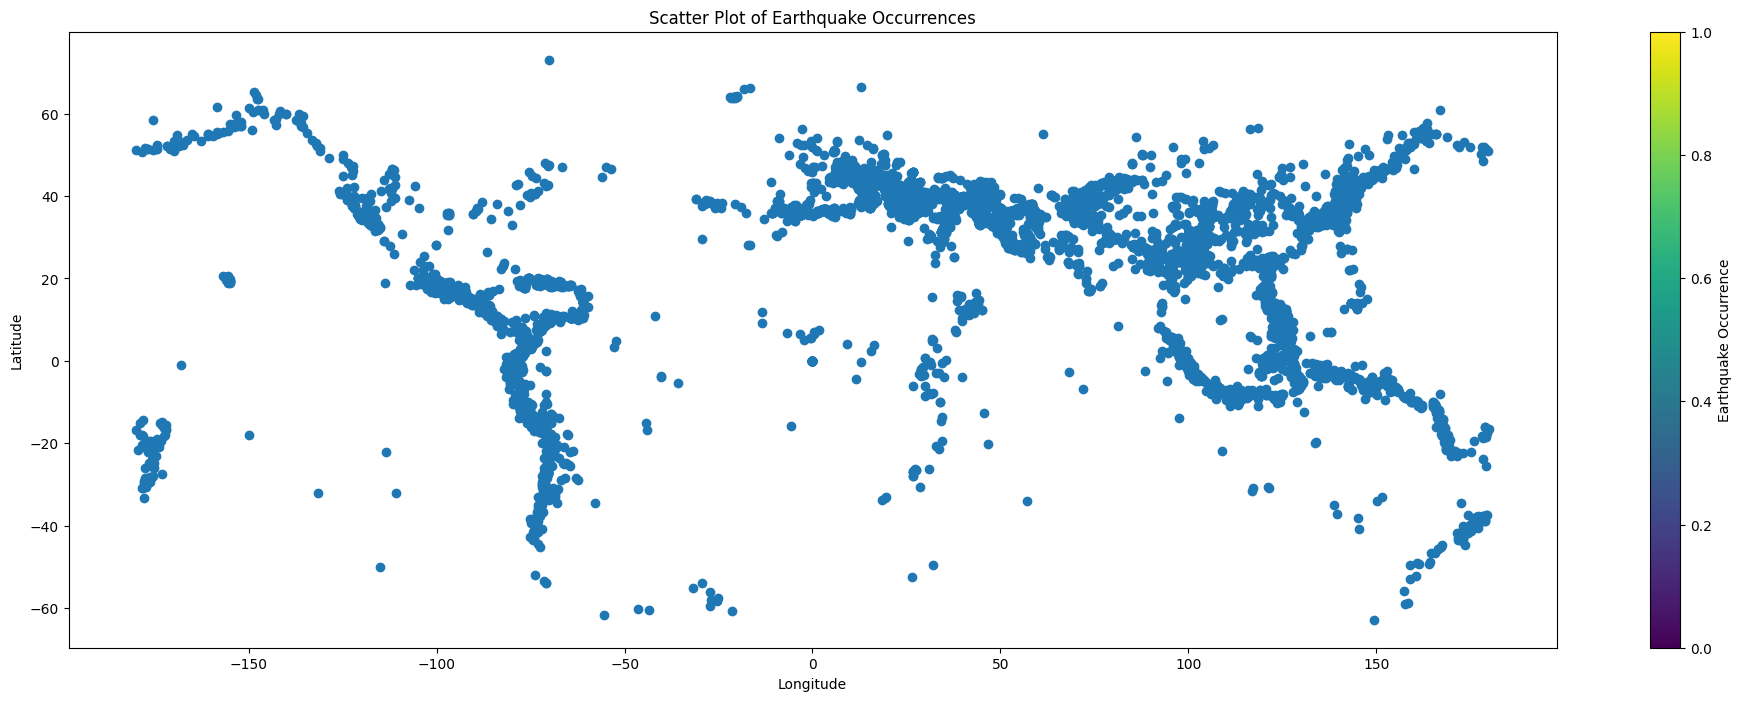

In [ ]:
# Visualization: Scatter plot of earthquake occurrences

df['longitude'] = df['longitude'].astype(float)
df['latitude'] = df['latitude'].astype(float)

plt.figure(figsize=(24, 8))
plt.scatter(df['longitude'], df['latitude'])
plt.title('Scatter Plot of Earthquake Occurrences')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Earthquake Occurrence')
plt.show()

**Conclusion**
*This database **"eqml_eqpredict"** contains 4 models namely **"eqml_eqpredict.eq_intensity_model"** to predict intensity of earthquake, **"eqml_eqpredict.eq_tsunami_model"** to give tsunami warnings, **"eqml_eqpredict.eq_prediction_model"** to predict earthquakes and **"eqml_eqpredict.eq_aftershocks_model"** to predict aftershock. Graph shows the high risk areas all over the globe.*